# Домашнее задание к лекции «Алгоритмы кластеризации»

## Задание
#### Цель: Изучить применение моделей кластеризации

#### Описание задания:
В домашнем задании нужно сократить число цветов в палитре изображения. Картинку для выполнения работы можно выбрать любую, главное условие – наличие на ней разных цветов, для того, чтобы результат работы моделей был заметен.

Для выполнения работы необходимо выделить кластеры в пространстве RGB, объекты соответствуют пикселям изображения. После выделения кластеров все пиксели, отнесенные в один кластер, заполняются одним цветом. Цвет – центроид соответствующего кластера.

In [44]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Этапы работы:

### 1. Получите данные и загрузите их в рабочую среду

#### a) Для отображения картинки воспользуйтесь вспомогательной функцией


In [45]:
!pip install opencv-python

In [46]:
import matplotlib.pyplot as plt
import cv2
import skimage

In [47]:
def draw_picture(image, title, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.title(title)
    plt.show()

#### b) Для загрузки картинки можно использовать код:

In [48]:
my_path = r"C:\Users\sveta\Documents\Netology\ML\img.jpg"
img = cv2.imread(my_path)

Размер изображения придется уменьшить, инече не заработает (мощности не зватит)

In [49]:
img = cv2.resize(img, (128, 128))

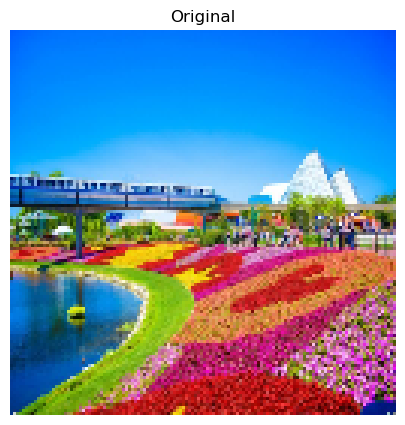

In [50]:
draw_picture(img, "Original")

### 2. Реализуйте три модели кластеризации:

In [51]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from skimage.metrics import structural_similarity as ssim

In [52]:
data = img.reshape((-1,3))
data = np.float32(data)

#### a) KMeans. Рассмотрите число кластеров K = 2, 5, 10, 20.
[OpenCV](https://docs.opencv.org/4.x/d1/d5c/tutorial_py_kmeans_opencv.html)

In [53]:
count_clusters = [2, 5, 10, 20]

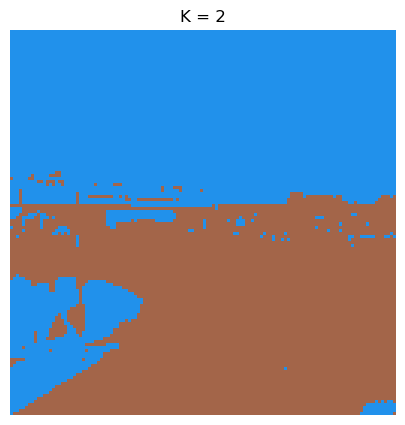

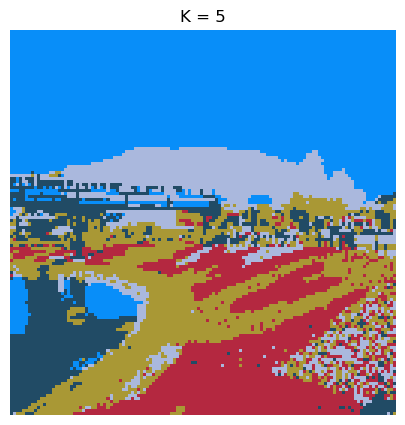

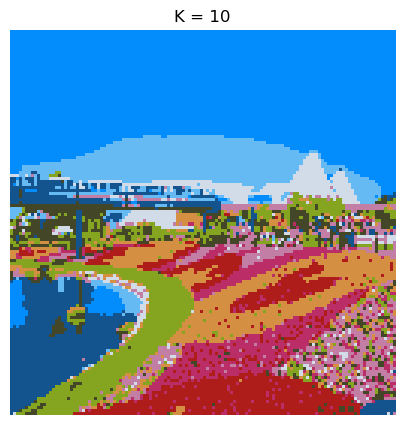

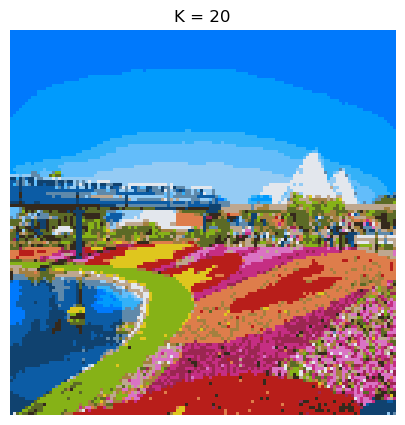

In [54]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
for i in count_clusters:
    ret, label, center = cv2.kmeans(data, i, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    draw_picture(res2, f'K = {i}')

#### b) DBSCAN

In [55]:
data_df = pd.DataFrame(data)
predict = DBSCAN(eps=3, min_samples=10).fit_predict(data_df)
predict_df = pd.DataFrame(predict)
data_df['cluster'] = predict_df
data_df.set_index('cluster', inplace=True)
train = data_df.copy()
for cluster in range(max(predict)):
    for col in train.columns:
        median = train.loc[cluster, col].median()
        train.loc[cluster, col] = median
train = train.to_numpy()

n_clusters = len(np.unique(predict))
print("Количество кластеров:", n_clusters)

Количество кластеров: 23


#### c) AgglomerativeClustering. Рассмотрите число кластеров K = 2, 5, 10, 20.

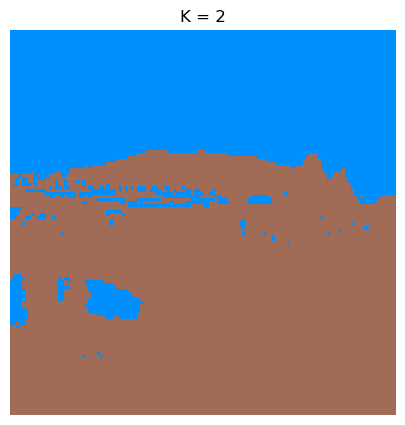

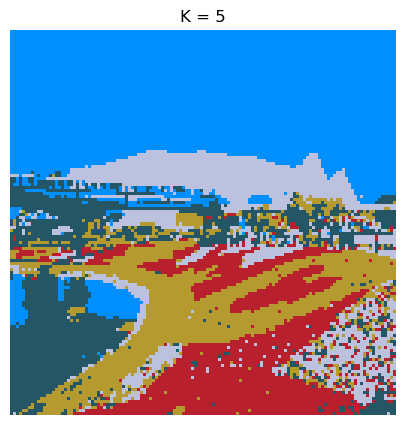

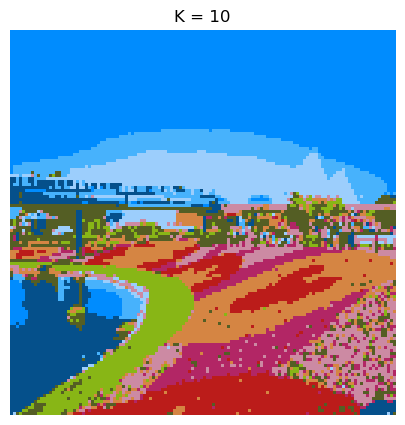

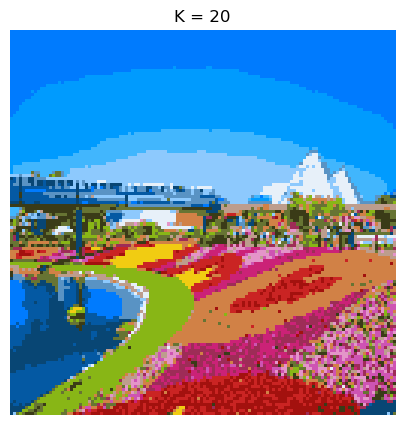

In [56]:
for i in count_clusters:
    data_df = pd.DataFrame(data)
    model = AgglomerativeClustering(n_clusters=i)
    predict = model.fit_predict(data_df)
    data_df['cluster'] = pd.DataFrame(predict)
    data_df.set_index('cluster', inplace=True)
    train = data_df.copy()
    for cluster in range(i):
        for col in train.columns:
            median = train.loc[cluster, col].median()
            train.loc[cluster, col] = median
    train = train.to_numpy()

    reconstructed_image = train.reshape(img.shape).astype(np.uint8)
    draw_picture(reconstructed_image, f'K = {i}')


### 3. Для каждой модели оцените потери от уменьшения цветов при помощи метрики SSIM.

In [57]:
# K-Means
for i in count_clusters:
    data_df = pd.DataFrame(data)
    model = KMeans(n_clusters=i)
    predict = model.fit_predict(data_df)
    data_df['cluster'] = pd.DataFrame(predict)
    data_df.set_index('cluster', inplace=True)
    train = data_df.copy()
    for cluster in range(i):
        for col in train.columns:
            median = train.loc[cluster, col].median()
            train.loc[cluster, col] = median
    train = train.to_numpy()
    print(f'K = {i}, SSIM = {ssim(data, train, channel_axis=1)}')

K = 2, SSIM = 0.045181069523096085
K = 5, SSIM = 0.20220236480236053
K = 10, SSIM = 0.31773319840431213
K = 20, SSIM = 0.4157572090625763


In [58]:
# DBSCAN
data_df = pd.DataFrame(data)
model = DBSCAN(eps=3)
predict = model.fit_predict(data_df)
predict_df = pd.DataFrame(predict)
data_df['cluster'] = predict_df
data_df.set_index('cluster', inplace=True)
train = data_df.copy()
for cluster in range(max(predict)):
    for col in train.columns:
        median = train.loc[cluster, col].median()
        train.loc[cluster, col] = median
train = train.to_numpy()
print(f'DBSCAN при eps = 3 даёт SSIM = {ssim(data, train, channel_axis=1)}')

DBSCAN при eps = 3 даёт SSIM = 0.6454311013221741


In [59]:
# AgglomerativeClustering
for i in count_clusters:
    data_df = pd.DataFrame(data)
    model = AgglomerativeClustering(n_clusters=i)
    predict = model.fit_predict(data_df)
    data_df['cluster'] = pd.DataFrame(predict)
    data_df.set_index('cluster', inplace=True)
    train = data_df.copy()
    for cluster in range(i):
        for col in train.columns:
            median = train.loc[cluster, col].median()
            train.loc[cluster, col] = median
    train = train.to_numpy()

    print(f'K = {i}, SSIM = {ssim(data, train, channel_axis=1)}')


K = 2, SSIM = 0.06458859145641327
K = 5, SSIM = 0.21407867968082428
K = 10, SSIM = 0.2907457649707794
K = 20, SSIM = 0.392219215631485


### 4. Сформулируйте выводы по проделанной работе.

1. Работа с изображениями требует очень много ресурсов. По скорости работы выгодно отличается K-Means.

2. Индекс структурного сходства (SSIM от англ. structure similarity) закономерно растет по мере увеличения количества кластеров (до определенного предела).

3. С текущими значениями лучше всего справился алгоритм DBSCAN. Он делит цвета на 23 кластера и точнее остальных разделяет цвета.